# **ITMO University**

## **Machine Learning and Robotics**


**Lab1**


**Student**: Bassel Alshawareb

# 2.1 Today task
Traffic signs classification

## ML systems pipeline



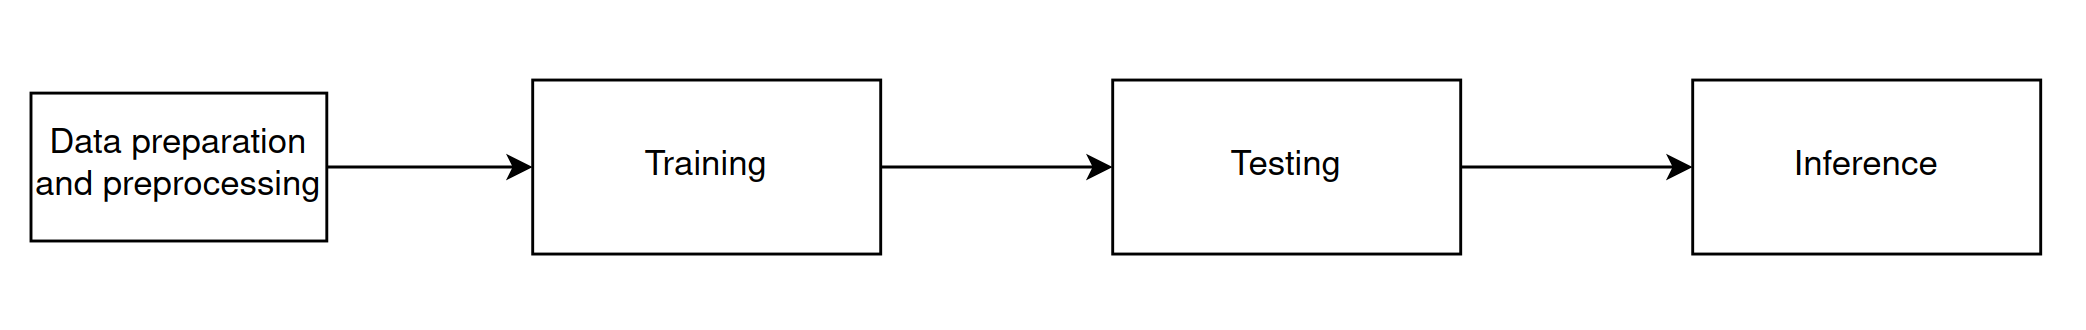

## Checking availability of GPU.

In [ ]:
!nvidia-smi

Fri May 12 13:18:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   78C    P0    33W /  70W |   3911MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Google Drive integration

In [ ]:
from google.colab import drive

some_folder = '/content/drive'
drive.mount(some_folder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading necessary libraries

In [ ]:
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, ColorJitter, ToPILImage, Resize, RandomRotation
from torch.utils.data import DataLoader
import torchvision
import torch
import time

## 2.2 Data preparation

For each training iteration we need a batch of preprocessed images (float tensor with shape BxHxWxC) and a batch of ground truth labels (integer tensor with shape Bx1).

How to load dataset?
 - load all iamges and labels im RAM simultaneously
 - use generator that will load images only when they will be used in training




## Dataset downloading

The dataset contains pictures of traffic signs containing numbers. The dataset contains a total of 1000 training images. 

In [ ]:
import os
import gdown
import shutil
# https://drive.google.com/file/d/1KyZjiUJfXoI53Jha1-CH3rma8dDg5-z7/view?usp=sharing
save_folder = './dataset'

os.makedirs(save_folder, exist_ok=True)

print("Downloading data archive...", end=" ")

id = '1KyZjiUJfXoI53Jha1-CH3rma8dDg5-z7'
gdown.download(f'https://drive.google.com/uc?id={id}', f"{save_folder}/dataset.zip", quiet=False)

shutil.unpack_archive(f"{save_folder}/dataset.zip", save_folder)

print("Done!")

Downloading...
From: https://drive.google.com/uc?id=1KyZjiUJfXoI53Jha1-CH3rma8dDg5-z7
To: /content/dataset/dataset.zip
100%|██████████| 642M/642M [00:21<00:00, 29.7MB/s]


Done!


In order to acces the data, we define our class that inherent the properties of Dataset class from torch.utils.data, which will allow us to access the data using a dataloader.

Found 2640 images for Test part


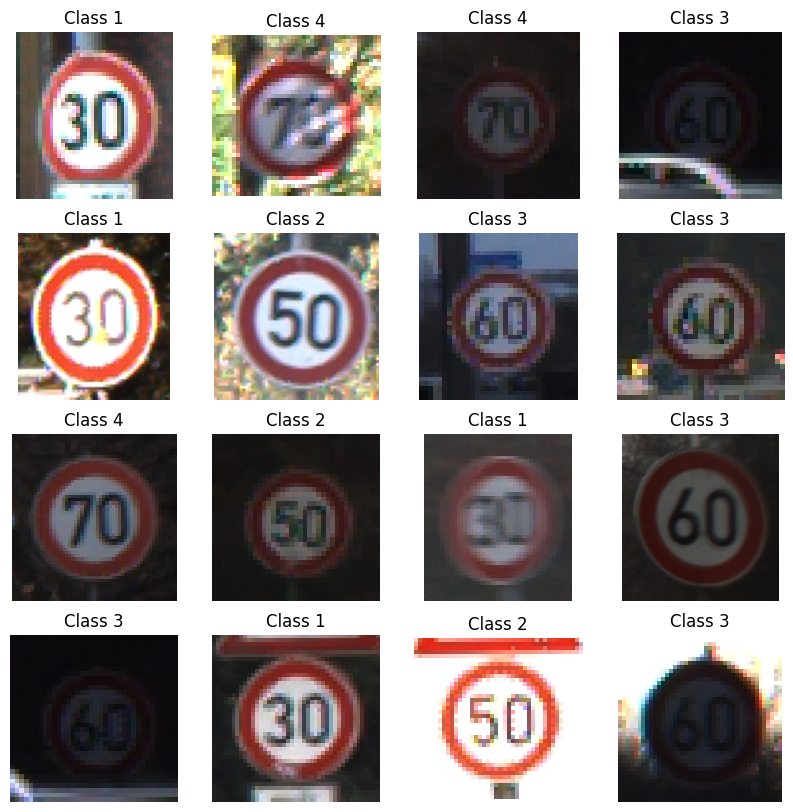

In [ ]:
from torch.utils.data import Dataset
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torchvision
from google.colab.patches import cv2_imshow
from PIL import Image
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt

class OurOwnDataset(Dataset):
    def __init__(self, root_folder, transforms=None, train=True):
        self.root_folder = root_folder
        self.transforms = transforms

        # choose type of dataset (train/test)
        annot_name = 'Train.csv' if train else 'Test.csv'
        self.df = pd.read_csv(f'{root_folder}/{annot_name}')

        # keep only 5 first classes (to reduce size of dataset)
        self.df = self.df[self.df['ClassId'] < 5]

        print(f'Found {len(self.df)} images for {annot_name.split(".")[0]} part')

    def __getitem__(self, i):

        path = os.path.join(self.root_folder, self.df['Path'].iloc[i])
        image = cv.imread(path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        if self.transforms:
            image = self.transforms(image)


        label = self.df['ClassId'].iloc[i]
       
        return image, label

    def __len__(self):
        return len(self.df)


dataset = OurOwnDataset('./dataset', train=False)
fig = plt.figure(figsize = (10,10))
for i in range(16):
    image, label = dataset.__getitem__(i)
    plt.subplot(4,4,i+1)
    plt.imshow(image)
    plt.title("Class "+str(label))
    plt.axis('off')


image transformations

In [ ]:
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, ColorJitter, ToPILImage, Resize, RandomRotation

target_transforms = Compose([
                             ToPILImage(),
                             Resize((224, 224)),
                             ToTensor(),
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # "magic numbers" - Imagenet statistics for each channel
])

train_dataset = OurOwnDataset('./dataset', transforms=target_transforms, train=True)
valid_dataset = OurOwnDataset('./dataset', transforms=target_transforms, train=False)


Found 8070 images for Train part
Found 2640 images for Test part


Collecting images to batches

In [ ]:
from torch.utils.data import DataLoader
batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)


## 2.2 Building of architecture

In 2013 Alexnet architecture won all classic methods in ILSVRC cometition on Imagenet dataset (1.3M images and 1 000 classes)
https://en.wikipedia.org/wiki/AlexNet

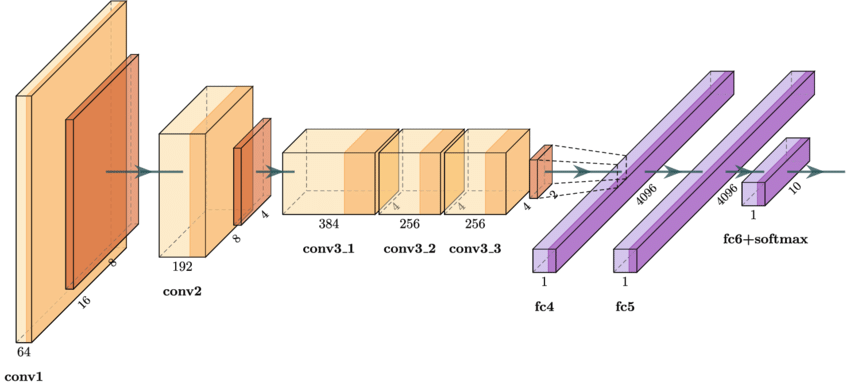

In [ ]:
from torch.nn.modules.pooling import MaxPool2d
from torch import nn
import torch

class OurAlexnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(*[
                                        nn.Conv2d(3, 96, (11, 11), stride=4, padding=1), # Conv2d(input_dimensions, out_dimensions, kernel_shape, stride=1, padding=0)
                                        nn.ReLU(),  # activation function
                                        nn.MaxPool2d((3, 3), stride=2), # MaxPool2d(kernel_shape, stride=1)
                                        nn.Conv2d(96, 256, (5, 5), padding=2),
                                        nn.ReLU(),
                                        nn.MaxPool2d((3, 3), stride=2),
                                        nn.Conv2d(256, 384, (3, 3), padding=1),
                                        nn.ReLU(),
                                        nn.Conv2d(384, 384, (3, 3), padding=1),
                                        nn.ReLU(),
                                        nn.Conv2d(384, 256, (3, 3), padding=1),
                                        nn.ReLU(),
                                        nn.MaxPool2d((3, 3), stride=2),
                                        nn.Flatten() # reshape tensort Batch_size X Channels X Width X Height -> Batch_size X (Channels * Width * Height)
                                        ])
        
        self.classifier = nn.Sequential(*[
                                        nn.Linear(5*5*256, 4096), # Linear(input_dimensions, out_dimensions)
                                        nn.ReLU(),
                                        nn.Dropout(0.5),
                                        nn.Linear(4096, 4096),
                                        nn.ReLU(),
                                        nn.Dropout(0.5),
                                        nn.Linear(4096, 1000), # last out dimension must be equal to number of classes
        ])

    def forward(self, x):
        features = self.feature_extractor(x)
        out = self.classifier(features)
        return out

net = OurAlexnet()
res = net(torch.randn((1, 3, 224, 224)))
res.shape

torch.Size([1, 1000])

## 2.3 Using SOTA models pre-trained on Imagenet

## 2.4 Model training
Training process can be divided on two steps:
 1. Initialization of model, optimizer and Loss dunction object
 2. Changing working mode of the model to "train"
 3. performing cycle:

```
for epoch in EPOCHS:
    # train stage
    for batch in all batches:
        perform optimization step
    # evaluation stage
    evaluate model
```


### Optimization step

 0. Move tensor to GPU (if necessary) 
 1. calculate model prediction
 2. calculate value of loss function
 3. perform gradient descent step

### model evaluation
 0. change working mode of model
 1. for all image in testing (validation) dataset calculate prediction
 2. calculate permormance matric based on predicted labels and ground-truth ones
 3. If there is no improvement in performance, stop training (optionally)


We define our training function that takes a model as an input, which will save time and space for applying the same training function on multiple models.

In [ ]:
def train(model, parameters, name = "myModel", epochs = 10, dataset_class = OurOwnDataset, transforms_aug = None):
  model.cuda()
  target_transforms = Compose([
                                ToPILImage(),
                                Resize((224, 224)),
                                ToTensor(),
                                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # "магические числа" - Imagenet статистика для каждого канала (mean - среднее, std - СКО)
    ])
  
  if transforms_aug is None:
    train_dataset = dataset_class('./dataset', transforms=target_transforms, train=True)
  else:
    train_dataset = dataset_class('./dataset', transforms=target_transforms, transforms_aug = transforms_aug, train=True)
  
  valid_dataset = OurOwnDataset('./dataset', transforms=target_transforms, train=False)

  batch_size = 16
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
  valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)

  # Model, optimizer, criterion initialization
  #################################################
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(params = parameters(), lr = 1e-3, momentum = 0.9)
  #################################################

  EPOCHS = epochs
  previous_accuracy = -1
  eps = 0.001
  since = time.time()
  for epoch in range(EPOCHS):
      print(f'Epoch {epoch}')
      # train stage
      #############################################
      for images, gt_labels in train_dataloader:
          images = images.cuda()
          gt_labels = gt_labels.cuda()
          # Implement optimization step
          optimizer.zero_grad()
          out = model(images)
          loss = criterion(out, gt_labels)
          loss.backward()
          optimizer.step()
          
      #############################################

      # validation stage
      # Implement validation here
      #############################################
      error = 0
      acc = 0
      with torch.no_grad(): # Using this wrapper prevents gradient calculation
          for images, gt_labels in valid_dataloader:
      
      #############################################
            images = images.cuda()
            gt_labels = gt_labels.cuda()
            out = model(images)
            loss = criterion(out,gt_labels)
            error += loss.detach().item()
            yhat = torch.argmax(out, axis = 1)
            acc += torch.eq(yhat, gt_labels).sum().detach().item()
      #  Print info about training process: current epoch, accuracy, sum/avg loss value
      total_error = error
      accuracy = acc/len(valid_dataset)
      #############################################
      print(f'\tTotal Loss {total_error}')
      print(f'\tAccuracy {accuracy}')
      #############################################
      
      
      # (optionally) stop training process if there is no improvement
      if abs(accuracy - previous_accuracy) <eps:
        break
      previous_accuracy = accuracy

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  model.cpu()
  # We save not the model, but only tensors of parameters
  saved_name = "/content/drive/My Drive/Colab Notebooks/" + name + ".pth"
  torch.save(model.state_dict(), saved_name)

  # load dictionary with pairs "parameter name": parameter_tensor

## 2.5 Training MobileNet V2 model without using pretrained weights

MobileNet is a computer vision model open-sourced by Google and designed for training classifiers. It uses depthwise convolutions to significantly reduce the number of parameters compared to other networks, resulting in a lightweight deep neural network.



### 1.1 Downloading the model





In this part, the network will be trained completely. There will be no pretrained weights used.

In [ ]:
from torchvision.models import mobilenet_v3_small

net = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)


classes = len(dataset.df['ClassId'].unique())
print(classes, ' classes in dataset')

net.classifier[-1] = torch.nn.Linear(net.classifier[-1].in_features, classes)


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


5  classes in dataset


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)




### 1.2 Cheking the architecture of the model.








In [ ]:
net

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

### 1.3 Training

In [ ]:
train(net, net.parameters(), "MobileNetv2")

Found 8070 images for Train part
Found 2640 images for Test part
Epoch 0
	Total Loss 229.63884699344635
	Accuracy 0.36174242424242425
Epoch 1
	Total Loss 216.67647516727448
	Accuracy 0.42272727272727273
Epoch 2
	Total Loss 125.4074814915657
	Accuracy 0.7356060606060606
Epoch 3
	Total Loss 62.707139153033495
	Accuracy 0.8723484848484848
Epoch 4
	Total Loss 46.62434066552669
	Accuracy 0.9128787878787878
Epoch 5
	Total Loss 31.79298196756281
	Accuracy 0.9428030303030303
Epoch 6
	Total Loss 25.42332904576324
	Accuracy 0.9545454545454546
Epoch 7
	Total Loss 22.79746149852872
	Accuracy 0.9549242424242425


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


<All keys matched successfully>

### 1.4 Saving and loading models

In [ ]:
from torch import nn

classes = len(dataset.df['ClassId'].unique())
# load dictionary with pairs "parameter name": parameter_tensor
states = torch.load('/content/drive/My Drive/Colab Notebooks/dict_checkpoint.pth')

# init architecture
net2 = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2')
net2.classifier[-1] = nn.Linear(net2.classifier[-1].in_features, classes)
# change default values with our trained ones
net2.load_state_dict(states)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip


<All keys matched successfully>

### 1.5 Model inference
For each input image:
  1. Make transformations
  2. Increase dimension (create a batch from one image)
  3. Move to GPU (if needed)
  4. Make a prediction
  5. Post-process of the model prediction (find the index with the maximum response, determine the probability of belonging to a class)


In [ ]:
valid_dataloader_it = iter(valid_dataloader)

Accuracy tensor(0.9570)
Class 20 F1 Score: 0.9
Class 30 F1 Score: 0.971830985915493
Class 50 F1 Score: 0.9538461538461539
Class 60 F1 Score: 0.9411764705882353
Class 70 F1 Score: 0.962962962962963


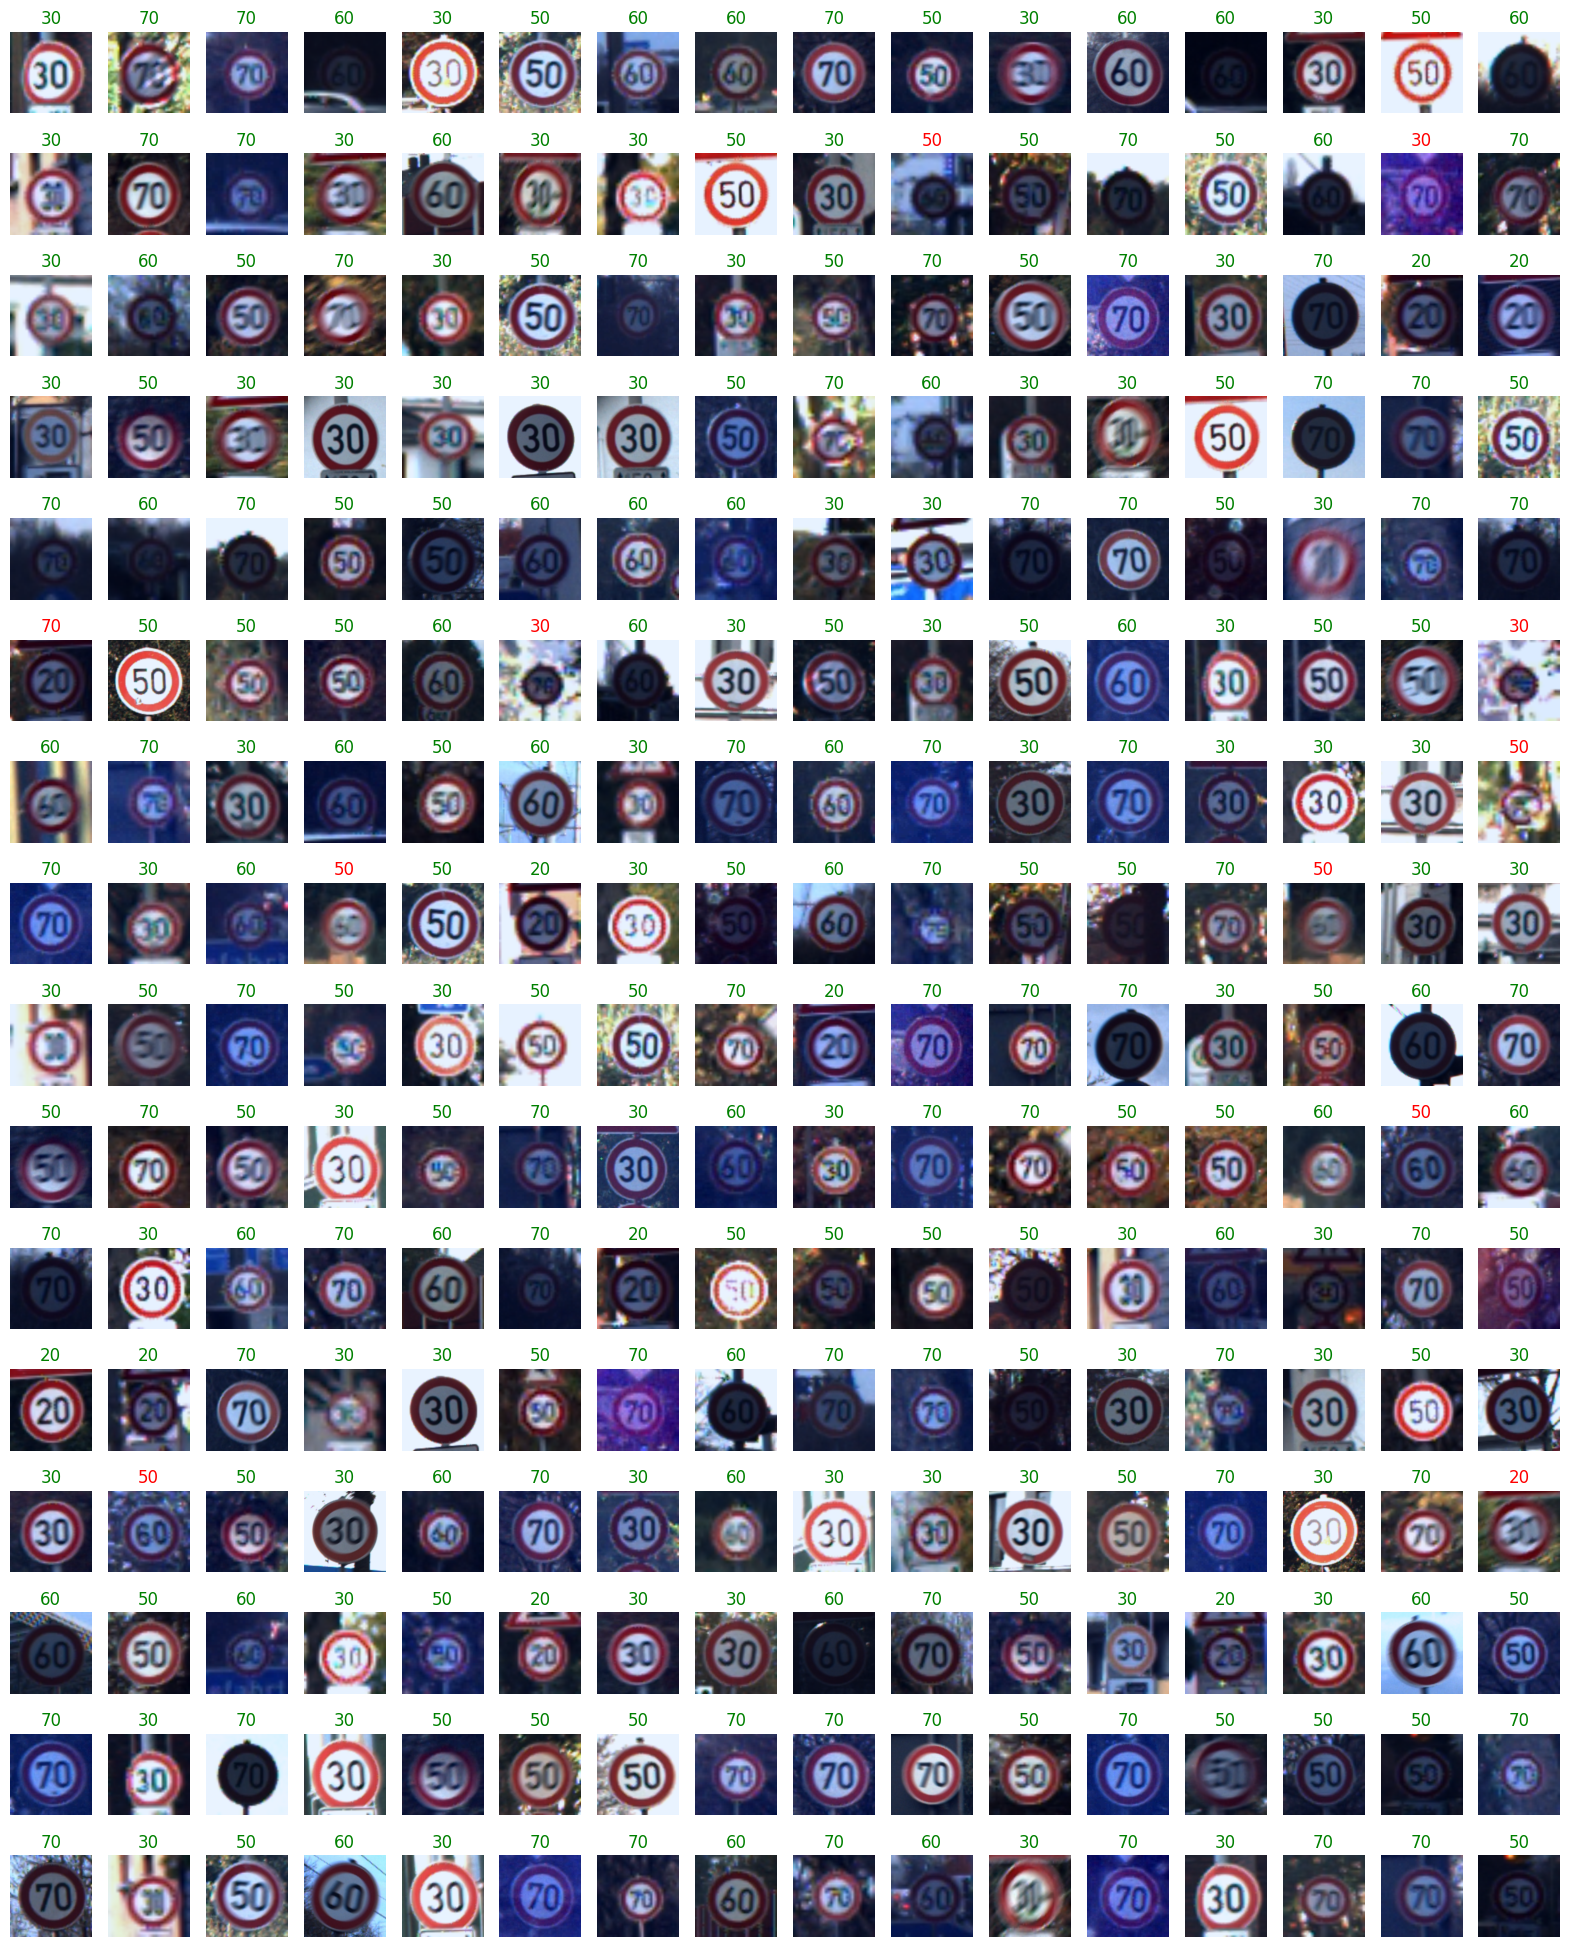

In [ ]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

def predict(image):
    out = net2(image)
    y_prob, yhat = torch.max(out, axis = 1)
    return yhat, y_prob.detach()

fig_counter = 0
plt.figure(figsize = (20,25))

#hash table for printing the real output of images
hash = dict({0:20, 1:30, 2:50, 3:60, 4:70})

ac_sm = 0
length = 0
yhat_all = torch.Tensor([])
y_all = torch.Tensor([])

for j in range(16):
  img, label = next(iter(valid_dataloader_it))

  prediction = predict(img)
  yhat_all = torch.cat((yhat_all, prediction[0]))
  y_all = torch.cat((y_all, label))
  mask = torch.eq(prediction[0], label)
  ac_sm += mask.sum()
  length += len(mask)
  
  for i in range(16):
    plt.subplot(16,16,i+j*16+1)
    plt.axis('off')
    imgi = torch.permute(img[i,...], (1,2,0))
    mn = torch.min(imgi).item()
    mx = torch.max(imgi).item()
    imgi = (imgi-mn)/(mx-mn)
    plt.imshow(imgi)
    if mask[i].item()==True:
      plt.title(str(hash[prediction[0][i].item()]), c = 'g')
    else:
      plt.title(str(hash[prediction[0][i].item()]), c = 'r')

accuracy = ac_sm/length
print("Accuracy", accuracy)

f1_scores = f1_score(y_all, yhat_all, average = None)
for i, el in enumerate(f1_scores):
  print(f'Class {hash[i]} F1 Score: {el}')

In [ ]:
for i in range(5):
  temp = len(dataset.df[dataset.df['ClassId']==i])
  print(f'Class {hash[i]}: {temp} \t\t F1 Score: {f1_scores[i]}')

Class 20: 60 		 F1 Score: 0.923076923076923
Class 30: 720 		 F1 Score: 0.9558823529411764
Class 50: 750 		 F1 Score: 0.9640287769784172
Class 60: 450 		 F1 Score: 0.9367088607594937
Class 70: 660 		 F1 Score: 0.9793103448275863


### 1.5 Analysing the results

The network showed good performance on classes that were trained with a big amount of data, while provided **lower performance** on classes with **smaller data**. However, the relationship here is not linear. There are multiple factors playing role here including the quality of the data itself for every class, and the diversity of data of every class in for both training and testing.
The required approach to solving this problem is to upsample the data of the classes with small data, by using augmentation, and downsampling the data of classes with big amount of data. This way will make sure the network will provide balanced performance amoung all classes.

## 2.6 Training MobileNet V2 model using pretrained weights

In [ ]:
from torchvision.models import mobilenet_v3_small

net = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)


classes = len(dataset.df['ClassId'].unique())
print(classes, ' classes in dataset')

net.classifier[-1] = torch.nn.Linear(net.classifier[-1].in_features, classes)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 301MB/s]

5  classes in dataset


In [ ]:
train(net, net.parameters, "MobileNetv2_pretrained")

Found 8070 images for Train part
Found 2640 images for Test part
Epoch 0
	Total Loss 12.43225081381388
	Accuracy 0.9772727272727273
Epoch 1
	Total Loss 7.9551473329775035
	Accuracy 0.9848484848484849
Epoch 2
	Total Loss 7.171870975391357
	Accuracy 0.9867424242424242
Epoch 3
	Total Loss 5.5945302976542735
	Accuracy 0.9871212121212121
Training complete in 2m 51s


The time needed for training the pretrained network is about 3 mins for getting an accuracy of 98.7% as opposed to training without using pretrained weight which did not exceed an accuracy of 96% and with more than 1h 30mins of time.

## Tasks
 - create a model that consists of pretrained feature extractor and your custom classification head


In the first part of this task, will will fine tune ResNet50 model, since it has only one fully-conencted layer (fc layer), which makes it easy to modify. 
The second part of this task will deal with VGG16, which has multiple fc layers in its classifier, and we will modify only the last fc layer.

## Fine Turning ResNet50

### Downloading and checking the architecture of Resnet50


Here we include the pretrained weight on ImageNet dataset. ImageNet dataset has 1000 classes, therefore, the output classes of the last fc layer (which is the only fc layer in ResNet50) is 1000.

In [ ]:
net = torch.hub.load("pytorch/vision", "resnet50", weights="IMAGENET1K_V2")
net

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 71.4MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Modifying the last Layer of ResNet50

To keep the algorithm flexible, we will not add numbers in code, we would rather keep them as variables, such that any change in the dataset will not require editing the code. The number of the output is taken from the number of uniques classes in the pandas table describing the datset.
To modify the fc layer, we overwrite it with an fc layer that has the same number of input features of ResNet50, and the same of output features as in our dataset.

In [ ]:
classes = len(dataset.df["ClassId"].unique())
net.fc = nn.Linear(net.fc.in_features, classes)

### Setting gradiant requirements for the last layer

By diffult, all parameters in the network models require gradiant. In our case, we want to modify the paramters only of the fc layer, so we will require_grad=False for all other parameters.

In [ ]:
for name, param in net.named_parameters():
  temp = name.split('.')
  req = temp[0]
  if req == "fc":
    param.requires_grad = True
  else:
    param.requires_grad = False

Then we check if we successfuly set the requirement of the gradiant only for the desired layer.

In [ ]:
for name,param in net.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

	 fc.weight
	 fc.bias


### Training ResNet50

Now that we sat the desired architecture of our network, we can start training. We need to import the dataset, and prepare the dataloader, and after that we starting the training loop.

In [ ]:
train(net, net.parameters, "ResNet50")

Found 8070 images for Train part
Found 2640 images for Test part
Epoch 0
	Total Loss 202.26596587896347
	Accuracy 0.5053030303030303
Epoch 1
	Total Loss 190.68332189321518
	Accuracy 0.5409090909090909
Epoch 2
	Total Loss 184.03936910629272
	Accuracy 0.5571969696969697
Epoch 3
	Total Loss 178.99717020988464
	Accuracy 0.578030303030303
Epoch 4


KeyboardInterrupt: ignored

The validation accuracy of the model after running 50 epochs does not exceed 65%. This is considered too low, and even more simpler models could results with better accuracy. The unsatisfying results are due to the fact that we were only updating the weights of the fc layer, without giving any consideration to the feature extraction layers. 

## 2.6 Trainig all parameters

In [ ]:
net = torch.hub.load("pytorch/vision", "resnet50", weights="IMAGENET1K_V2")
classes = len(dataset.df["ClassId"].unique())
net.fc = nn.Linear(net.fc.in_features, classes)

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


In [ ]:
train(net, net.parameters, "ResNet50_all_parameters", epochs = 3)

Found 8070 images for Train part
Found 2640 images for Test part
Epoch 0
	Total Loss 5.129830585676245
	Accuracy 0.990909090909091
Epoch 1


KeyboardInterrupt: ignored

## 2.7 Changing the classifier

In [ ]:
net = torch.hub.load("pytorch/vision", "resnet50", weights="IMAGENET1K_V2")
classes = len(dataset.df["ClassId"].unique())
net.fc = nn.Sequential(*[nn.Linear(net.fc.in_features, net.fc.in_features//2),
                         nn.ReLU(),
                         nn.Linear(net.fc.in_features//2, classes),
                         ])

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


In [ ]:
train(net, net.parameters, "resnet50_different_head", epochs = 3)

Found 8070 images for Train part
Found 2640 images for Test part
Epoch 0
	Total Loss 47.37638157606125
	Accuracy 0.9075757575757576
Epoch 1
	Total Loss 15.076209612889215
	Accuracy 0.9708333333333333
Epoch 2
	Total Loss 11.010478891839739
	Accuracy 0.9791666666666666
Training complete in 4m 45s


## 2.8 Working with MNIST Dataset

In [ ]:
import torch
import torchvision
from torch.utils.data import Dataset
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torchvision
from google.colab.patches import cv2_imshow
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
mnist_train_dataset = torchvision.datasets.MNIST('./', train=True, download = True)
mnist_test_dataset = torchvision.datasets.MNIST('./', train=False, download = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 183820172.10it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 94122528.22it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 59028955.00it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 22518355.52it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
mnist_train_dataset.data.shape

torch.Size([60000, 28, 28])

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
class MyDataset(Dataset):
  def __init__(self, transforms = None, transforms_aug = None, train = True, n_augmented = 200):
    super(MyDataset, self).__init__()
    self.id = 0
    self.transforms = transforms
    self.transforms_aug = transforms_aug
    self.n_augmented = n_augmented
    if train:
      self.classes = mnist_train_dataset.train_labels
      datas = torchvision.datasets.MNIST('./', train=True, download = True)
    else:
      self.classes = mnist_train_dataset.test_labels
      datas = torchvision.datasets.MNIST('./', train=False, download = True)

    self.data = datas.data
    self.path = "./Augmentation"
    self.isExist = os.path.exists(self.path)
    try:
      !mkdir "./Augmentation"
    except:
      pass
    
  def __getitem__(self, i):
    
    img0 = self.data[i].repeat(3,1,1)
    y = self.classes[i]
    name = self.path +"/" + str(self.id) + "imageof" +str(y.item())+".png"
    if self.transforms:
      img = self.transforms(img0)

    if self.isExist == False:
      if self.transforms_aug is not None:
        if self.id<self.n_augmented:
          img = self.transforms_aug(img0)
          torchvision.utils.save_image(img, name)
          self.id += 1

    return img, y
    
  def __len__(self):
    return len(self.data)



In [ ]:
import glob
import cv2
class augmentedData(Dataset):
  def __init__(self):
    super(augmentedData, self).__init__()
    self.path = "Augmentation/*.png"
    self.paths = glob.glob(self.path)
    
  def __getitem(self, i):
    pth = self.paths[i]
    img = cv2.imread(pth)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    y = int(pth.split("imageof")[1].split(".")[0])
    return img, y

  def __len__(self):
    return len(self.paths)

data = augmentedData()

In [ ]:
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, ColorJitter, ToPILImage, Resize, RandomRotation, RandomCrop

target_aug = Compose([
                             ToPILImage(),
                             RandomCrop(22),
                             RandomRotation(30),
                             Resize((28, 28)),
                             ToTensor(),
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # "magic numbers" - Imagenet statistics for each channel
])


In [ ]:
import torch.nn as nn
# Do it here
class MyNet(nn.Module):
  def __init__(self):
    super(MyNet, self).__init__()
    self.features = nn.Sequential(*[
        nn.Conv2d(3, 64, (3,3), stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d((2,2), stride = 2),
        nn.Conv2d(64, 128, (3,3), stride = 1, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d((2,2), stride = 2),
        nn.Conv2d(128, 128, (3,3), stride = 1, padding = 1),
        nn.ReLU(),
        nn.Flatten()]
    )
    
    self.classifier = nn.Sequential(
        nn.Linear(7*7*128, 1000),
        nn.ReLU(),
        nn.Linear(1000,10)
    )
  def forward(self, x):
    out1 = self.features(x)
    out2 = self.classifier(out1)
    return out2

net = MyNet()

In [ ]:
net = torch.hub.load("pytorch/vision", "resnet50", weights="IMAGENET1K_V2")
net.fc = nn.Linear(net.fc.in_features, 10)

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


In [ ]:
def train(model, parameters, name = "myModel", epochs = 10, transforms_aug = None):
  model.cuda()
  target_transforms = Compose([
                                ToPILImage(),
                                Resize((224, 224)),
                                ToTensor(),
                                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # "магические числа" - Imagenet статистика для каждого канала (mean - среднее, std - СКО)
    ])
  
  train_dataset = MyDataset(transforms=target_transforms, transforms_aug = transforms_aug, train=True)
  valid_dataset = MyDataset(transforms=target_transforms, train=False)

  batch_size = 64
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
  valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)
  augmented_loader = None 
  # Model, optimizer, criterion initialization
  #################################################
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(params = parameters(), lr = 1e-3, momentum = 0.9)
  #################################################

  EPOCHS = epochs
  previous_accuracy = -1
  eps = 0.001
  k = -1
  since = time.time()
  for epoch in range(EPOCHS):
      print(f'Epoch {epoch}')
      # train stage
      #############################################
      for images, gt_labels in train_dataloader:
          images = images.cuda()
          gt_labels = gt_labels.cuda()
          # Implement optimization step
          optimizer.zero_grad()
          out = model(images)
          loss = criterion(out, gt_labels)
          loss.backward()
          optimizer.step()
          
      #############################################
      if k == -1:
          k = 1
          train_dataset = augmentedData()
          augmented_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
      print("starting reading augmented data")
      for images, gt_labels in augmented_loader:
          print(gt_labels)
          images = images.cuda()
          gt_labels = gt_labels.cuda()
          # Implement optimization step
          optimizer.zero_grad()
          out = model(images)
          loss = criterion(out, gt_labels)
          loss.backward()
          optimizer.step()
      # validation stage
      # Implement validation here
      #############################################
      error = 0
      acc = 0
      with torch.no_grad(): # Using this wrapper prevents gradient calculation
          for images, gt_labels in valid_dataloader:
      
      #############################################
            images = images.cuda()
            gt_labels = gt_labels.cuda()
            out = model(images)
            loss = criterion(out,gt_labels)
            error += loss.detach().item()
            yhat = torch.argmax(out, axis = 1)
            acc += torch.eq(yhat, gt_labels).sum().detach().item()
      #  Print info about training process: current epoch, accuracy, sum/avg loss value
      total_error = error
      accuracy = acc/len(valid_dataset)
      #############################################
      print(f'\tTotal Loss {total_error}')
      print(f'\tAccuracy {accuracy}')
      #############################################
      
      
      # (optionally) stop training process if there is no improvement
      if abs(accuracy - previous_accuracy) <eps:
        break
      previous_accuracy = accuracy

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  model.cpu()
  # We save not the model, but only tensors of parameters
  saved_name = "/content/drive/My Drive/Colab Notebooks/" + name + ".pth"
  torch.save(model.state_dict(), saved_name)

  # load dictionary with pairs "parameter name": parameter_tensor

In [ ]:
import time
train(net, net.parameters, name = "mynet on mnist", epochs = 3, transforms_aug= target_aug)

mkdir: cannot create directory ‘./Augmentation’: File exists


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


mkdir: cannot create directory ‘./Augmentation’: File exists
starting training
Epoch 0
starting reading augmented data


NotImplementedError: ignored